## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


## Setup

A clean and explicit setup ensures reproducibility: imports are centralised, the sample window is defined once, and display options are set for consistent outputs across machines.


In [8]:
# =========================
# Setup — Lecture 4
# =========================

import numpy as np
import pandas as pd
import requests

# Display options for clear tables in Colab
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

# Sample window (as requested)
START = "2021-01-01"
END   = "2024-12-31"

# BCRP series used in the lecture notebook
BCRP_CODES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

print("Setup complete.")
print("Sample window:", START, "to", END)
print("BCRP series:", BCRP_CODES)


Setup complete.
Sample window: 2021-01-01 to 2024-12-31
BCRP series: ['PD04637PD', 'PD04639PD', 'PD04704XD', 'PD04701XD']


Constructing and printing the URL makes the data source **auditable** and the request **replicable**.  
The lecture uses the **BCRP Data API** by concatenating series codes with **hyphens (-)**.


In [9]:
# Build the BCRPData API URL
series_str = "-".join(BCRP_CODES)
bcrp_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{series_str}/json/{START}/{END}/ing"

print("BCRPData API URL:")
print(bcrp_url)


BCRPData API URL:
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2021-01-01/2024-12-31/ing


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


Before reshaping into a wide time-series table, it is best practice to first organise the raw observations into a tidy (long) structure, where each row corresponds to one observation for one series on one date. This format is transparent, facilitates validation by series, and aligns with standard data-science conventions for clean data pipelines.

In [10]:
# --- Download data from the BCRP API ---
response = requests.get(bcrp_url, timeout=60)
response.raise_for_status()
payload = response.json()

# Inspect structure
print("Payload keys:", list(payload.keys()))

# Ensure periods exist and show first observation
assert "periods" in payload and len(payload["periods"]) > 0, "No periods returned. Check URL or date range."

print("Number of periods:", len(payload["periods"]))
print("First period dict:", payload["periods"][0])
print("First 5 raw dates:", [p["name"] for p in payload["periods"][:5]])

Payload keys: ['config', 'periods']
Number of periods: 1043
First period dict: {'name': '04.Jan.21', 'values': ['3.624', '3.624', '359.177118159863', '1943.2']}
First 5 raw dates: ['04.Jan.21', '05.Jan.21', '06.Jan.21', '07.Jan.21', '08.Jan.21']


In [11]:
rows = []
for obs in payload["periods"]:
    date_raw = str(obs["name"])
    vals = obs["values"]

    # Defensive date cleaning:
    # - remove time suffix if present (e.g., "2021-01-04T00:00:00")
    # - strip spaces
    date_clean = date_raw.split("T")[0].strip()

    for code, val in zip(BCRP_CODES, vals):
        rows.append((date_raw, date_clean, code, val))

peru_tidy = pd.DataFrame(rows, columns=["date_raw", "date_clean", "series", "value_raw"])

# Robust date parsing: do NOT force a single format, because your API output may vary
peru_tidy["date"] = pd.to_datetime(peru_tidy["date_clean"], errors="coerce")

# Robust numeric parsing
peru_tidy["value"] = (
    peru_tidy["value_raw"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)
peru_tidy["value"] = pd.to_numeric(peru_tidy["value"], errors="coerce")

# IMPORTANT: check parsing success BEFORE dropping
print("Rows before dropping NaT:", len(peru_tidy))
print("Unparsed dates (NaT):", peru_tidy["date"].isna().sum())

# Now clean and keep the required tidy columns
peru_tidy = (
    peru_tidy
    .dropna(subset=["date"])
    .sort_values(["date", "series"])
    .reset_index(drop=True)
)[["date", "series", "value"]]

# Guaranteed print (works even if display fails)
print("\nTidy table preview (first 12 rows):")
print(peru_tidy.head(12).to_string(index=False))

print("\nTidy table shape:", peru_tidy.shape)
print("Series present:", peru_tidy["series"].unique())


Rows before dropping NaT: 4172
Unparsed dates (NaT): 344

Tidy table preview (first 12 rows):
      date    series       value
2021-01-01 PD04637PD         NaN
2021-01-01 PD04639PD         NaN
2021-01-01 PD04701XD 1891.100000
2021-01-01 PD04704XD  351.148537
2021-01-04 PD04637PD    3.624000
2021-01-04 PD04639PD    3.624000
2021-01-04 PD04701XD 1943.200000
2021-01-04 PD04704XD  359.177118
2021-01-05 PD04637PD    3.627500
2021-01-05 PD04639PD    3.627000
2021-01-05 PD04701XD 1940.350000
2021-01-05 PD04704XD  358.973002

Tidy table shape: (3828, 3)
Series present: ['PD04637PD' 'PD04639PD' 'PD04701XD' 'PD04704XD']


C:\Users\User\AppData\Local\Temp\ipykernel_22588\2888885512.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  peru_tidy["date"] = pd.to_datetime(peru_tidy["date_clean"], errors="coerce")


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


A wide-format table is the standard representation for time-series analysis: it stores one observation per date and one column per variable. This structure facilitates direct comparisons across series, straightforward merging with US asset returns, and transparent econometric modelling. The cleaning step consists of mapping raw BCRP codes to semantically meaningful column names and reshaping the tidy dataset via a pivot operation.

In [12]:
# --- Map BCRP codes to the lecture notebook variable names ---
code_to_name = {
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "gold",
    "PD04701XD": "copper",
}

# Defensive check: confirm all codes are present before reshaping
missing = set(code_to_name.keys()) - set(peru_tidy["series"].unique())
assert not missing, f"Missing expected series in peru_tidy: {missing}"

# --- Reshape from tidy (long) to wide (time-series) format ---
peru_wide = (
    peru_tidy
    .assign(series=lambda d: d["series"].map(code_to_name))
    .pivot_table(index="date", columns="series", values="value", aggfunc="last")
    .sort_index()
    .reset_index()
)

# Ensure the column order matches the notebook requirement exactly
peru_wide = peru_wide[["date", "fx_interbank", "fx_sbs", "gold", "copper"]]

# Quick inspection
print("Wide table preview:")
print(peru_wide.head(10).to_string(index=False))

print("\nWide table shape:", peru_wide.shape)
print("Columns:", list(peru_wide.columns))

Wide table preview:
      date  fx_interbank  fx_sbs       gold  copper
2021-01-01           NaN     NaN 351.148537 1891.10
2021-01-04      3.624000   3.624 359.177118 1943.20
2021-01-05      3.627500   3.627 358.973002 1940.35
2021-01-06      3.624833   3.625 368.747917 1931.95
2021-01-07      3.620667   3.620 364.529508 1920.10
2021-01-08      3.611000   3.610 369.496345 1862.90
2021-01-11      3.615167   3.615 360.673973 1847.25
2021-01-12      3.606333   3.606 362.102789 1841.25
2021-01-13      3.612500   3.610 361.082206 1858.85
2021-01-14      3.610667   3.610 362.987294 1841.75

Wide table shape: (957, 5)
Columns: ['date', 'fx_interbank', 'fx_sbs', 'gold', 'copper']


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


US financial assets are retrieved using Yahoo Finance via the yfinance package, which is widely adopted in empirical finance for obtaining daily market data. Adjusted prices are used to ensure that the resulting series account for dividends and stock splits, thereby making subsequent return calculations economically meaningful. The data are organised in a tidy (long) format, with one observation per asset and date, which is consistent with best practices for financial time-series analysis.

In [13]:
import yfinance as yf
import pandas as pd

USA_TICKERS = ["SPY", "TLT", "GLD"]

yf_data = yf.download(
    tickers=USA_TICKERS,
    start=START,
    end=END,
    auto_adjust=True,
    progress=False
)

print("Empty?", yf_data.empty)
print("Columns names:", getattr(yf_data.columns, "names", None))
print("Columns sample:", list(yf_data.columns)[:5])

# --- Handle MultiIndex with order (Price, Ticker) ---
if isinstance(yf_data.columns, pd.MultiIndex):
    # Your case: level 0 is Price field, level 1 is Ticker
    lvl0 = yf_data.columns.get_level_values(0)
    lvl1 = yf_data.columns.get_level_values(1)

    if "Close" in set(lvl0):
        close_wide = yf_data["Close"].copy()     # columns become tickers
    elif "close" in set(lvl0):
        close_wide = yf_data["close"].copy()
    else:
        raise KeyError(f"No Close field in level 0. Found level0 fields: {sorted(set(lvl0))}")

    usa_tidy = (
        close_wide
        .reset_index()
        .melt(id_vars="Date", var_name="ticker", value_name="close")
        .rename(columns={"Date": "date"})
    )

else:
    # Single-index fallback
    if "Close" in yf_data.columns:
        usa_tidy = yf_data[["Close"]].rename(columns={"Close": "close"}).reset_index()
    elif "close" in yf_data.columns:
        usa_tidy = yf_data[["close"]].rename(columns={"close": "close"}).reset_index()
    else:
        raise KeyError(f"No Close column found. Columns: {list(yf_data.columns)}")

    usa_tidy = usa_tidy.rename(columns={"Date": "date"})
    usa_tidy["ticker"] = USA_TICKERS[0]
    usa_tidy = usa_tidy[["date", "ticker", "close"]]

# Clean types and order
usa_tidy["date"] = pd.to_datetime(usa_tidy["date"])
usa_tidy["close"] = pd.to_numeric(usa_tidy["close"], errors="coerce")
usa_tidy = (
    usa_tidy
    .dropna(subset=["close"])
    .sort_values(["date", "ticker"])
    .reset_index(drop=True)
)[["date", "ticker", "close"]]

print("\nUS assets (tidy) — preview:")
print(usa_tidy.head(12).to_string(index=False))

print("\nTidy shape:", usa_tidy.shape)
print("Tickers present:", usa_tidy["ticker"].unique())

Empty? False
Columns names: ['Price', 'Ticker']
Columns sample: [('Close', 'GLD'), ('Close', 'SPY'), ('Close', 'TLT'), ('High', 'GLD'), ('High', 'SPY')]

US assets (tidy) — preview:
      date ticker      close
2021-01-04    GLD 182.330002
2021-01-04    SPY 344.256714
2021-01-04    TLT 134.713715
2021-01-05    GLD 182.869995
2021-01-05    SPY 346.627716
2021-01-05    TLT 133.713226
2021-01-06    GLD 179.899994
2021-01-06    SPY 348.700073
2021-01-06    TLT 130.968384
2021-01-07    GLD 179.479996
2021-01-07    SPY 353.880859
2021-01-07    TLT 129.813950

Tidy shape: (3012, 3)
Tickers present: ['GLD' 'SPY' 'TLT']


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


Daily returns are computed as percentage changes in adjusted closing prices, which is the standard transformation in empirical finance for analysing asset performance and risk. Returns are calculated by ticker to ensure that observations are not incorrectly mixed across assets. After computing returns, it is essential to validate that no infinite values are present, as these may arise from zero prices or data glitches and would invalidate subsequent statistical analysis.

In [14]:
# --- Compute daily returns by ticker ---
usa_returns = usa_tidy.copy()

usa_returns["ret"] = (
    usa_returns
    .groupby("ticker")["close"]
    .pct_change()
)

# --- Validate: check for infinite values ---
has_inf = np.isinf(usa_returns["ret"]).any()
print("Any infinite return values?", has_inf)

# Replace infinite values with NaN (defensive cleaning)
usa_returns.loc[np.isinf(usa_returns["ret"]), "ret"] = np.nan

# Final check
assert not np.isinf(usa_returns["ret"]).any(), "Infinite values still present in returns!"

# Preview
print("\nUS assets with returns — preview:")
print(
    usa_returns
    .head(12)
    .to_string(index=False)
)

Any infinite return values? False

US assets with returns — preview:
      date ticker      close       ret
2021-01-04    GLD 182.330002       NaN
2021-01-04    SPY 344.256714       NaN
2021-01-04    TLT 134.713715       NaN
2021-01-05    GLD 182.869995  0.002962
2021-01-05    SPY 346.627716  0.006887
2021-01-05    TLT 133.713226 -0.007427
2021-01-06    GLD 179.899994 -0.016241
2021-01-06    SPY 348.700073  0.005979
2021-01-06    TLT 130.968384 -0.020528
2021-01-07    GLD 179.479996 -0.002335
2021-01-07    SPY 353.880859  0.014857
2021-01-07    TLT 129.813950 -0.008815


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


Comparing exchange rate levels (rather than returns) allows us to assess whether alternative official FX measures move consistently over time. In the Peruvian case, the interbank exchange rate and the SBS exchange rate are expected to track each other closely, as both reflect transactions in the same underlying FX market but may differ slightly due to institutional coverage and reporting conventions.

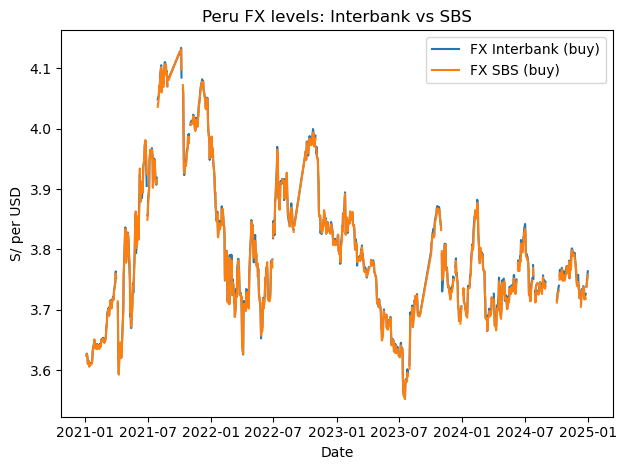

In [15]:
import matplotlib.pyplot as plt

# --- FX levels plot ---
plt.figure()
plt.plot(peru_wide["date"], peru_wide["fx_interbank"], label="FX Interbank (buy)")
plt.plot(peru_wide["date"], peru_wide["fx_sbs"], label="FX SBS (buy)")

plt.title("Peru FX levels: Interbank vs SBS")
plt.xlabel("Date")
plt.ylabel("S/ per USD")
plt.legend()
plt.tight_layout()
plt.show()


## Short comment
Interbank and SBS exchange rate series move almost identically over the sample period, indicating a high degree of consistency across official FX measures in Peru. Minor and transitory differences are observed, which likely reflect institutional reporting practices rather than economically meaningful deviations. Overall, the close co-movement confirms that both series capture the same underlying exchange rate dynamics.

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  
The share of positive-return days provides a non-parametric measure of asset performance that focuses on the frequency of gains rather than their magnitude. Unlike the mean return, this statistic is robust to outliers and offers complementary insight into the persistence of positive daily performance across assets.

In [16]:
# --- Share of positive-return days by ticker ---
positive_share = (
    usa_returns
    .dropna(subset=["ret"])
    .groupby("ticker")["ret"]
    .apply(lambda x: (x > 0).mean())
    .rename("share_positive_days")
)

# Display result
print("Share of positive-return days by ticker:")
print(positive_share.to_string())


Share of positive-return days by ticker:
ticker
GLD    0.520439
SPY    0.541376
TLT    0.484546


## Academic note
The proportion of positive-return days is computed for each US asset as the fraction of trading days with strictly positive daily returns. This measure captures asymmetries in daily performance and complements traditional moment-based statistics by focusing on the sign rather than the size of returns.

8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  
A bar chart provides a clear visual comparison of the frequency of positive-return days across assets. Adding numerical annotations above each bar improves interpretability by allowing the reader to immediately identify exact proportions without referring to axis scales, which is consistent with good practice in data visualisation for empirical finance.

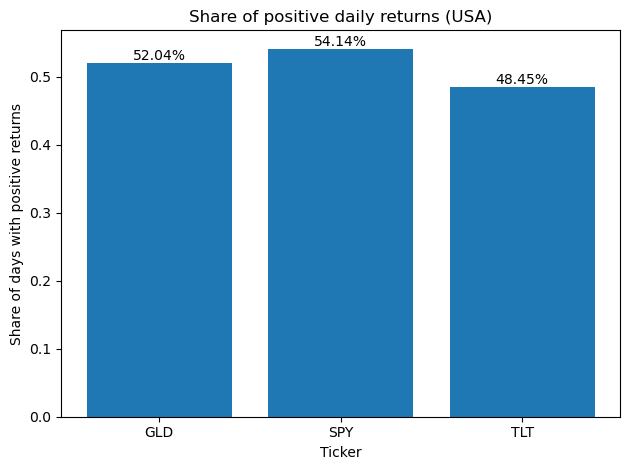

In [17]:
import matplotlib.pyplot as plt

# --- Bar chart of positive-return shares ---
plt.figure()
bars = plt.bar(
    positive_share.index,
    positive_share.values
)

plt.title("Share of positive daily returns (USA)")
plt.xlabel("Ticker")
plt.ylabel("Share of days with positive returns")

# --- Add annotations above each bar ---
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2%}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

## Academic note
The bar chart highlights differences in the proportion of positive-return days across US assets. Annotating each bar with its exact value enhances readability and facilitates direct comparison, complementing the numerical summary presented earlier.

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  
Histograms are a standard tool for comparing empirical distributions, as they reveal differences in dispersion, skewness, and concentration of observations. Comparing the distribution of Peruvian gold prices (London spot) with the GLD ETF allows us to assess whether the financial representation of gold exhibits similar distributional properties to the underlying commodity price, acknowledging that the two series are expressed in different units and scales.

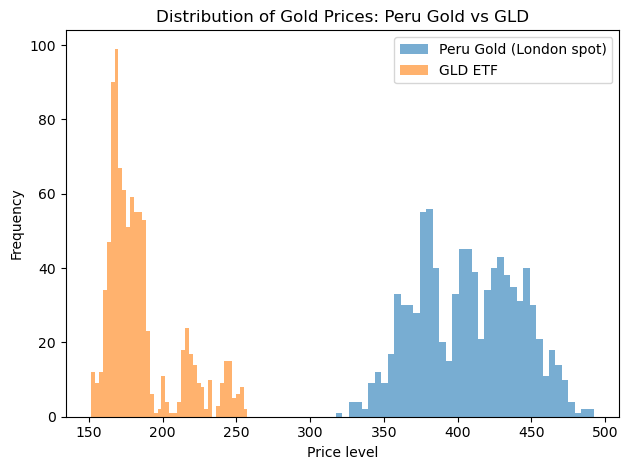

In [18]:
import matplotlib.pyplot as plt

# --- Prepare gold series from Peru and GLD ---
peru_gold = (
    peru_wide[["date", "gold"]]
    .dropna()
)

gld_prices = (
    usa_returns
    .loc[usa_returns["ticker"] == "GLD", ["date", "close"]]
    .rename(columns={"close": "gld"})
    .dropna()
)

# Align by date to ensure comparability
gold_compare = (
    peru_gold
    .merge(gld_prices, on="date", how="inner")
)

# --- Histogram comparison ---
plt.figure()
plt.hist(
    gold_compare["gold"],
    bins=40,
    alpha=0.6,
    label="Peru Gold (London spot)"
)
plt.hist(
    gold_compare["gld"],
    bins=40,
    alpha=0.6,
    label="GLD ETF"
)

plt.title("Distribution of Gold Prices: Peru Gold vs GLD")
plt.xlabel("Price level")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## Academic note
The histogram comparison shows that, despite differences in scale, the distributions of Peruvian gold prices and the GLD ETF exhibit broadly similar shapes. This reflects the fact that GLD closely tracks the underlying gold market, although financial frictions and ETF-specific features may introduce small distributional differences.

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  
While histograms summarise distributions through bins (and are therefore sensitive to bin choice), the Empirical Cumulative Distribution Function (ECDF) provides a bin-free representation of the entire distribution. The ECDF is particularly useful for comparing percentiles and tail behaviour, which are central to risk analysis.

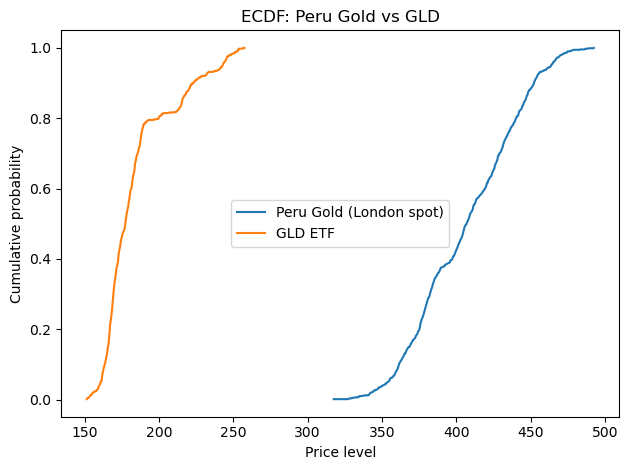

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# --- Build ECDFs ---
ecdf_peru_gold = ECDF(gold_compare["gold"])
ecdf_gld = ECDF(gold_compare["gld"])

# Grid for plotting
x_peru = np.linspace(gold_compare["gold"].min(), gold_compare["gold"].max(), 400)
x_gld  = np.linspace(gold_compare["gld"].min(),  gold_compare["gld"].max(),  400)

# --- ECDF plot ---
plt.figure()
plt.plot(x_peru, ecdf_peru_gold(x_peru), label="Peru Gold (London spot)")
plt.plot(x_gld,  ecdf_gld(x_gld),        label="GLD ETF")

plt.title("ECDF: Peru Gold vs GLD")
plt.xlabel("Price level")
plt.ylabel("Cumulative probability")
plt.legend()
plt.tight_layout()
plt.show()


## Comment: ECDF vs Histogram
Relative to the histogram, the ECDF provides a smoother and bin-independent comparison of the two distributions. It allows for a direct assessment of percentile differences and tail behaviour, which are less transparent in histograms. While the histogram highlights the overall shape and dispersion, the ECDF makes it easier to evaluate distributional dominance and to compare quantiles across the two gold series.

11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  

To study the relationship between domestic exchange rate movements and global financial conditions, the exchange rate is first transformed into daily percentage changes. This places the FX series on the same scale as asset returns, allowing for a coherent comparison. The relationship with US equity returns (SPY) is then visualised using a scatter plot, which is well suited for assessing the sign, strength, and linearity of co-movement.


C:\Users\User\AppData\Local\Temp\ipykernel_22588\3527664117.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fx_change["FX_change"] = fx_change["fx_interbank"].pct_change()


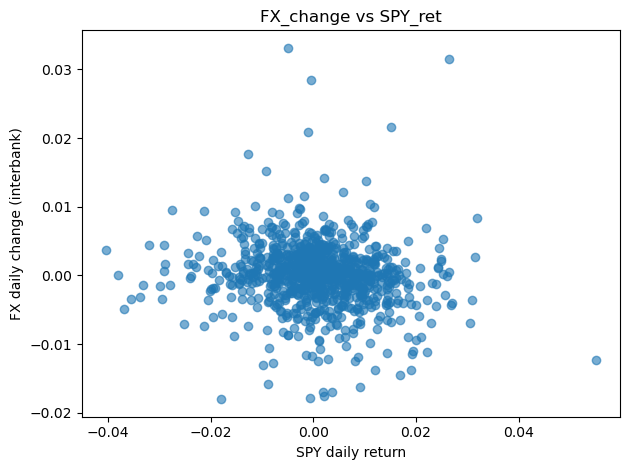

Merged dataset preview:
      date  fx_interbank  FX_change   SPY_ret
2021-01-05      3.627500   0.000966  0.006887
2021-01-06      3.624833  -0.000735  0.005979
2021-01-07      3.620667  -0.001149  0.014857
2021-01-08      3.611000  -0.002670  0.005698
2021-01-11      3.615167   0.001154 -0.006741


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Build FX_change (daily percentage change of the interbank FX rate) ---
fx_change = (
    peru_wide[["date", "fx_interbank"]]
    .copy()
)

fx_change["FX_change"] = fx_change["fx_interbank"].pct_change()

# --- Extract SPY returns ---
spy_returns = (
    usa_returns
    .loc[usa_returns["ticker"] == "SPY", ["date", "ret"]]
    .rename(columns={"ret": "SPY_ret"})
)

# --- Merge FX_change with SPY_ret by date ---
fx_spy = (
    fx_change
    .merge(spy_returns, on="date", how="inner")
    .dropna(subset=["FX_change", "SPY_ret"])
)

# --- Scatter plot ---
plt.figure()
plt.scatter(
    fx_spy["SPY_ret"],
    fx_spy["FX_change"],
    alpha=0.6
)

plt.title("FX_change vs SPY_ret")
plt.xlabel("SPY daily return")
plt.ylabel("FX daily change (interbank)")
plt.tight_layout()
plt.show()

# Quick inspection
print("Merged dataset preview:")
print(fx_spy.head().to_string(index=False))


Academic note
The scatter plot relates daily changes in the Peruvian interbank exchange rate to daily returns on the S&P 500 ETF (SPY). This visualisation allows for an assessment of contemporaneous co-movement between domestic FX dynamics and global equity market conditions, highlighting whether periods of strong US equity performance tend to coincide with exchange rate appreciation or depreciation.

12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign. 
Correlation provides a concise summary of the linear co-movement between exchange rate changes and equity returns. While it does not imply causality, the sign and magnitude of the correlation offer useful descriptive evidence on whether global equity market movements tend to coincide with currency appreciation or depreciation in Peru.


In [21]:
# --- Compute correlation ---
corr_fx_spy = fx_spy["FX_change"].corr(fx_spy["SPY_ret"])

print("Correlation between FX_change and SPY_ret:", corr_fx_spy)

Correlation between FX_change and SPY_ret: -0.11700630868558459


In [22]:
# --- Correlation table ---
corr_table = (
    fx_spy[["FX_change", "SPY_ret"]]
    .corr()
)

print("Correlation table:")
print(corr_table.to_string())

Correlation table:
           FX_change   SPY_ret
FX_change   1.000000 -0.117006
SPY_ret    -0.117006  1.000000


Academic note
The correlation between daily exchange rate changes and US equity returns summarises their contemporaneous linear relationship. The sign of the correlation is interpreted through a risk-on/risk-off framework, while recognising that correlation captures association rather than causal effects.

13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  

While correlation summarises co-movement, a simple linear regression allows us to quantify the marginal association between exchange rate changes and equity returns. Estimating the regression of daily FX changes on SPY returns provides an interpretable slope coefficient that measures how exchange rate movements are associated, on average, with changes in US equity market performance.

In [23]:
import statsmodels.api as sm

# --- Prepare regression variables ---
X = fx_spy["SPY_ret"]
y = fx_spy["FX_change"]

# Add constant term
X = sm.add_constant(X)

# --- Estimate OLS regression ---
reg_fx_spy = sm.OLS(y, X, missing="drop").fit()

# Display regression results
print(reg_fx_spy.summary())

                            OLS Regression Results                            
Dep. Variable:              FX_change   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.76
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           0.000373
Time:                        01:42:04   Log-Likelihood:                 3612.5
No. Observations:                 921   AIC:                            -7221.
Df Residuals:                     919   BIC:                            -7211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.043e-05      0.000      0.571      0.5

Academic note
The regression coefficient captures the marginal association between US equity returns and daily exchange rate changes. Although the estimated relationship does not imply causality, the sign and magnitude of the coefficient provide informative descriptive evidence on how Peruvian FX dynamics co-move with global equity market condition

14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering. 

In applied data work, it is essential to distinguish between position-based selection (which depends purely on row/column order) and value-based selection (which depends on economic conditions in the data). .iloc selects observations by integer location, whereas conditional filtering selects observations that satisfy a logical criterion (e.g., unusually high FX levels). Confusing these two approaches can lead to incorrect sub-samples and flawed inference.

In [24]:
# -------------------------
# A) .iloc (position-based)
# -------------------------
# Select the first 5 rows and the first 3 columns by *position*,
# regardless of the values contained in those rows/columns.
iloc_example = peru_wide.iloc[:5, :3]

print("A) .iloc selection (first 5 rows, first 3 columns):")
print(iloc_example.to_string(index=False))


# ----------------------------------
# B) Conditional filtering (value-based)
# ----------------------------------
# Select dates where FX interbank is above its 95th percentile (high-FX days).
fx_threshold = peru_wide["fx_interbank"].quantile(0.95)

cond_example = peru_wide.loc[peru_wide["fx_interbank"] > fx_threshold,
                             ["date", "fx_interbank", "fx_sbs"]].head(10)

print("\nB) Conditional filtering (fx_interbank > 95th percentile):")
print(f"Threshold (95th percentile) = {fx_threshold:.6f}")
print(cond_example.to_string(index=False))

A) .iloc selection (first 5 rows, first 3 columns):
      date  fx_interbank  fx_sbs
2021-01-01           NaN     NaN
2021-01-04      3.624000   3.624
2021-01-05      3.627500   3.627
2021-01-06      3.624833   3.625
2021-01-07      3.620667   3.620

B) Conditional filtering (fx_interbank > 95th percentile):
Threshold (95th percentile) = 4.034575
      date  fx_interbank  fx_sbs
2021-07-30      4.048500   4.036
2021-08-02      4.055000   4.050
2021-08-03      4.060167   4.070
2021-08-04      4.071333   4.072
2021-08-05      4.069167   4.064
2021-08-06      4.087833   4.085
2021-08-09      4.105000   4.102
2021-08-10      4.061000   4.060
2021-08-11      4.087833   4.081
2021-08-12      4.092667   4.096


Academic note
.iloc selects observations purely by their position in the dataset and is therefore sensitive to the current ordering of rows and columns. By contrast, conditional filtering selects observations based on their values (e.g., unusually high exchange-rate days), which is typically the appropriate approach when defining economically meaningful sub-samples.

15. Create missing data on purpose in one series and apply imputation (as in the notebook).  

Missing data are common in macro-financial time series due to reporting gaps, market closures, or data processing issues. To demonstrate a robust workflow, we intentionally introduce missing observations into one series and then apply a transparent imputation strategy. Time-based interpolation is appropriate for daily series because it respects temporal ordering and provides smooth estimates between adjacent observations, while forward/back filling ensures no remaining missing values at the boundaries.

In [25]:
import numpy as np
import pandas as pd

# Work on a copy to avoid overwriting the original dataset
peru_imp = peru_wide.copy()

# Choose one series (as an example): copper
target_col = "copper"

# --- 1) Create missing values on purpose ---
# We randomly drop a small number of existing (non-missing) observations.
rng = np.random.default_rng(123)

valid_idx = peru_imp.index[peru_imp[target_col].notna()]
n_drop = min(30, len(valid_idx))  # drop up to 30 points (defensive)
drop_idx = rng.choice(valid_idx, size=n_drop, replace=False)

peru_imp.loc[drop_idx, target_col] = np.nan

print(f"Artificially introduced missing values in '{target_col}': {n_drop}")
print("Missing count after dropping:", peru_imp[target_col].isna().sum())

# --- 2) Imputation (as in a typical lecture notebook) ---
# Time interpolation uses the date order; then ffill/bfill handles edge cases.
# (interpolate requires date to be the index or uses order; here we set index temporarily)
tmp = peru_imp.set_index("date").sort_index()

tmp[f"{target_col}_imputed"] = (
    tmp[target_col]
    .interpolate(method="time")
    .ffill()
    .bfill()
)

peru_imp = tmp.reset_index()

# --- 3) Quick verification: show a few imputed rows ---
check = peru_imp.loc[drop_idx, ["date", target_col, f"{target_col}_imputed"]].sort_values("date").head(10)

print("\nPreview of imputed rows:")
print(check.to_string(index=False))

Artificially introduced missing values in 'copper': 30
Missing count after dropping: 30

Preview of imputed rows:
      date  copper  copper_imputed
2021-01-21     NaN     1854.650000
2021-02-03     NaN     1809.500000
2021-03-12     NaN     1724.100000
2021-08-19     NaN     1781.250000
2021-08-31     NaN     1797.204688
2021-11-15     NaN     1863.160000
2021-11-16     NaN     1864.030000
2021-12-20     NaN     1797.237500
2021-12-23     NaN     1789.425000
2021-12-31     NaN     1809.412500


Academic note
Missing values were introduced artificially into the copper series to emulate typical data gaps in time-series datasets. Imputation was performed using time-based interpolation to preserve temporal structure, with forward/back filling applied to remove any remaining boundary missingness. This yields a complete series suitable for plotting and regression without dropping entire dates.

16. Standardize a variable (z-score) and plot **before vs after**.  

Standardisation (z-scores) rescales a variable to have mean zero and unit variance. This removes units and scale, facilitating comparisons across variables and improving numerical stability in statistical models. Plotting the series before and after standardisation illustrates that the transformation preserves temporal dynamics while normalising magnitude.

Mean (before): 3.7948847222225877
Std  (before): 0.11625608779249925
Mean (after): 1.153073737856303e-15
Std  (after): 1.0000000000000009


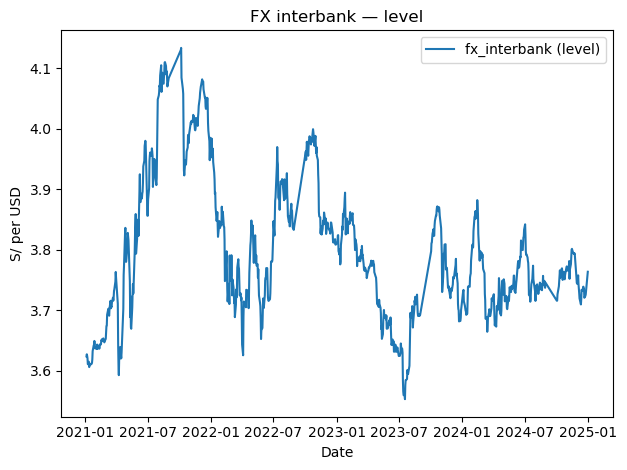

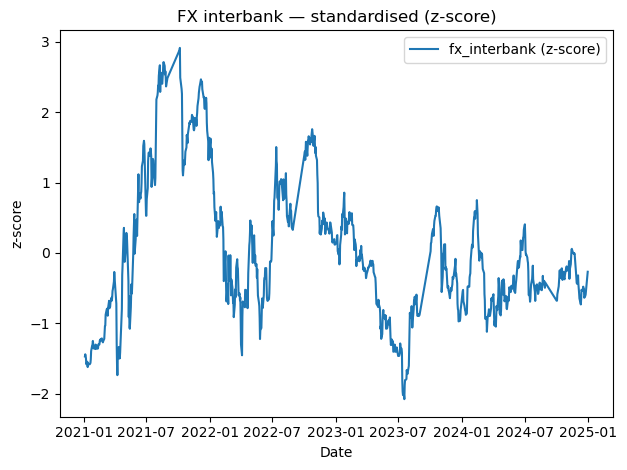

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# --- Select variable to standardise ---
x = (
    peru_wide[["date", "fx_interbank"]]
    .dropna()
    .set_index("date")
)

# --- Compute z-score ---
mu = x["fx_interbank"].mean()
sd = x["fx_interbank"].std(ddof=0)  # population sd for standardisation
x["fx_interbank_z"] = (x["fx_interbank"] - mu) / sd

print("Mean (before):", mu)
print("Std  (before):", sd)
print("Mean (after):", x["fx_interbank_z"].mean())
print("Std  (after):", x["fx_interbank_z"].std(ddof=0))

# --- Plot before standardisation ---
plt.figure()
plt.plot(x.index, x["fx_interbank"], label="fx_interbank (level)")
plt.title("FX interbank — level")
plt.xlabel("Date")
plt.ylabel("S/ per USD")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot after standardisation ---
plt.figure()
plt.plot(x.index, x["fx_interbank_z"], label="fx_interbank (z-score)")
plt.title("FX interbank — standardised (z-score)")
plt.xlabel("Date")
plt.ylabel("z-score")
plt.legend()
plt.tight_layout()
plt.show()


Academic note
The FX Interbank series is standardised using z-scores to remove scale and units. The before–after plots show that standardisation preserves the time-series pattern while centring the distribution at zero and normalising its variance, which is useful for comparative analysis and regression modelling.

17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  

Extreme daily returns are informative about tail risk and stress episodes in financial markets. Identifying the day with the largest absolute return highlights periods of exceptional volatility. Annotating this observation directly on the returns plot improves interpretability and mirrors standard exploratory exercises used to visualise extreme market events.




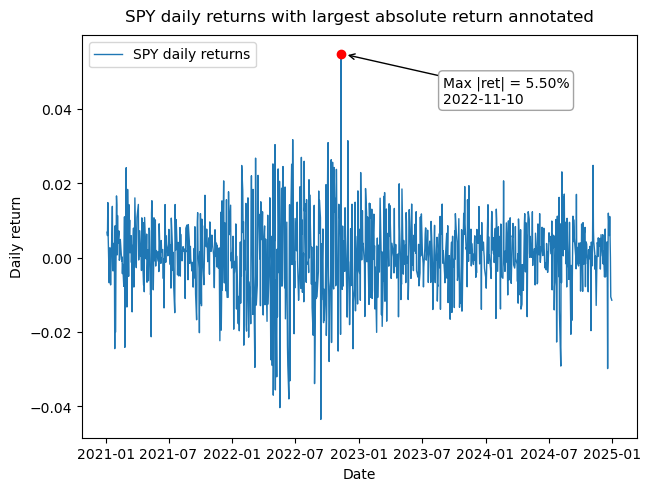

In [28]:
import matplotlib.pyplot as plt

# --- Extract SPY returns only ---
spy_ret = (
    usa_returns
    .loc[usa_returns["ticker"] == "SPY", ["date", "ret"]]
    .dropna()
    .copy()
)

# --- Identify largest absolute return ---
max_idx = spy_ret["ret"].abs().idxmax()
max_date = spy_ret.loc[max_idx, "date"]
max_ret  = spy_ret.loc[max_idx, "ret"]

# --- Plot ---
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(
    spy_ret["date"],
    spy_ret["ret"],
    label="SPY daily returns",
    linewidth=1.0
)

ax.scatter(max_date, max_ret, color="red", zorder=4)

# --- Annotation INSIDE the axes ---
ax.annotate(
    text=f"Max |ret| = {max_ret:.2%}\n{max_date.date()}",
    xy=(max_date, max_ret),              # point to highlight
    xycoords="data",
    xytext=(0.65, 0.90),                  # INSIDE the axes (fraction)
    textcoords="axes fraction",
    ha="left",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9),
    arrowprops=dict(
        arrowstyle="->",
        lw=1.0,
        shrinkA=0,
        shrinkB=5,
        connectionstyle="arc3"
    )
)

ax.set_title("SPY daily returns with largest absolute return annotated", pad=10)
ax.set_xlabel("Date")
ax.set_ylabel("Daily return")
ax.legend(loc="upper left")

plt.show()

Academic note
The largest absolute daily return in SPY is identified and annotated in the returns plot. This highlights an extreme market movement and provides a visual illustration of tail risk in US equity returns, consistent with the exploratory analysis presented in the lecture exercise.

18. Save one figure into `/figures` using `savefig` and verify the file exists.  

Saving figures programmatically ensures reproducibility and allows results to be archived, shared, or included directly in reports. Verifying that the file exists after saving provides a simple integrity check that confirms the output has been generated successfully.

In [29]:
from pathlib import Path
import matplotlib.pyplot as plt

# Ensure figures directory exists
fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

# File path
fig_path = fig_dir / "spy_returns_annotated.png"

# --- Recreate the figure (or run this immediately after plotting) ---
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(
    spy_ret["date"],
    spy_ret["ret"],
    label="SPY daily returns",
    linewidth=1.0
)

ax.scatter(max_date, max_ret, color="red", zorder=4)

ax.annotate(
    text=f"Max |ret| = {max_ret:.2%}\n{max_date.date()}",
    xy=(max_date, max_ret),
    xycoords="data",
    xytext=(0.65, 0.90),
    textcoords="axes fraction",
    ha="left",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9),
    arrowprops=dict(arrowstyle="->", lw=1.0)
)

ax.set_title("SPY daily returns with largest absolute return annotated")
ax.set_xlabel("Date")
ax.set_ylabel("Daily return")
ax.legend(loc="upper left")

# --- Save figure ---
plt.savefig(fig_path, dpi=300)
plt.close(fig)

# --- Verify file exists ---
file_exists = fig_path.exists()

print("Figure saved at:", fig_path.resolve())
print("File exists?", file_exists)


Figure saved at: C:\Users\User\Documents\GitHub\Python-for-Finance\homeworks\Assignment_3\group_9_ass_3_2026_folder\figures\spy_returns_annotated.png
File exists? True


In [30]:
from pathlib import Path

fig_path = Path("figures/spy_returns_annotated.png")
print("Exists?", fig_path.exists())
print("Absolute path:", fig_path.resolve())


Exists? True
Absolute path: C:\Users\User\Documents\GitHub\Python-for-Finance\homeworks\Assignment_3\group_9_ass_3_2026_folder\figures\spy_returns_annotated.png


Academic note
The annotated SPY returns figure is saved programmatically using savefig and stored in a dedicated figures directory. A verification step confirms that the file was created successfully, ensuring reproducibility and proper output management.

19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  

Summary statistics provide a concise quantitative description of the distribution of asset returns. Reporting moments and quantiles (such as the 5th and 95th percentiles) is standard practice in empirical finance, as it allows for an assessment of central tendency, dispersion, and tail risk across assets in a comparable format.

In [31]:
import pandas as pd

# --- Select returns only and drop missing values ---
returns_only = (
    usa_returns
    .loc[:, ["ticker", "ret"]]
    .dropna()
)

# --- Build summary statistics table by ticker ---
summary_stats = (
    returns_only
    .groupby("ticker")["ret"]
    .agg(
        mean="mean",
        sd="std",
        min="min",
        p5=lambda x: x.quantile(0.05),
        median="median",
        p95=lambda x: x.quantile(0.95),
        max="max"
    )
)

# Display table
print("Summary statistics for daily returns:")
print(summary_stats.to_string(float_format="{:.6f}".format))

Summary statistics for daily returns:
            mean       sd       min        p5    median      p95      max
ticker                                                                   
GLD     0.000317 0.009028 -0.035683 -0.015321  0.000381 0.015154 0.032148
SPY     0.000577 0.010384 -0.043482 -0.016660  0.000652 0.016634 0.054954
TLT    -0.000413 0.010675 -0.034183 -0.017329 -0.000441 0.017012 0.038474


Academic note
The table reports summary statistics for daily returns, including measures of central tendency, dispersion, and tail behaviour. Quantiles are included to characterise downside and upside risk, providing a more complete description of return distributions than moments alone.

20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.

Value at Risk (VaR) is a standard risk measure that summarises potential losses over a given horizon at a specified confidence level. The historical VaR approach is non-parametric: it relies directly on the empirical distribution of past returns and therefore avoids distributional assumptions. Computing a 95% historical VaR for a 60/40 portfolio provides an intuitive measure of downside risk under observed market conditions.

In [32]:
import pandas as pd
import numpy as np

# --- Extract SPY and TLT returns ---
spy_tlt = (
    usa_returns
    .loc[usa_returns["ticker"].isin(["SPY", "TLT"]), ["date", "ticker", "ret"]]
    .dropna()
)

# Pivot to wide format: date | SPY | TLT
spy_tlt_wide = (
    spy_tlt
    .pivot(index="date", columns="ticker", values="ret")
    .dropna()
)

# --- Define portfolio weights (60/40) ---
w_spy = 0.60
w_tlt = 0.40

# --- Compute portfolio daily returns ---
spy_tlt_wide["port_ret"] = (
    w_spy * spy_tlt_wide["SPY"] +
    w_tlt * spy_tlt_wide["TLT"]
)

# --- Historical 95% VaR ---
# VaR is defined as the 5th percentile of the return distribution
var_95 = np.percentile(spy_tlt_wide["port_ret"], 5)

print("Historical 95% VaR (daily) for 60/40 SPY–TLT portfolio:")
print(f"{var_95:.4%}")


Historical 95% VaR (daily) for 60/40 SPY–TLT portfolio:
-1.3326%


Academic note
The historical 95% Value at Risk is computed as the 5th percentile of the empirical distribution of daily returns for a 60/40 SPY–TLT portfolio. This measure indicates the maximum expected daily loss under normal market conditions with 95% confidence, based solely on past observed returns.

--------------------------------------------------------------------

# Lecture 4
## Peru (BCRPData API)
- FX: Interbank USD/PEN (buy) vs SBS banking system USD/PEN (buy)
- Commodities: Gold and Copper reference prices (daily series published by BCRP)
## USA (Yahoo Finance via yfinance)
- Market: SPY (US equities), TLT (US long bonds), GLD (gold ETF)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [34]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

# 0) Load real financial data
If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [35]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()

Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


# 1) Quantities
## Exercise 1.1 — FX level comparison (Peru)
Tasks

1. Filter peru to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (date as index).
3. Plot both FX levels in the same line chart.
4. Create spread = sbs - interbank and plot it in a separate figure.

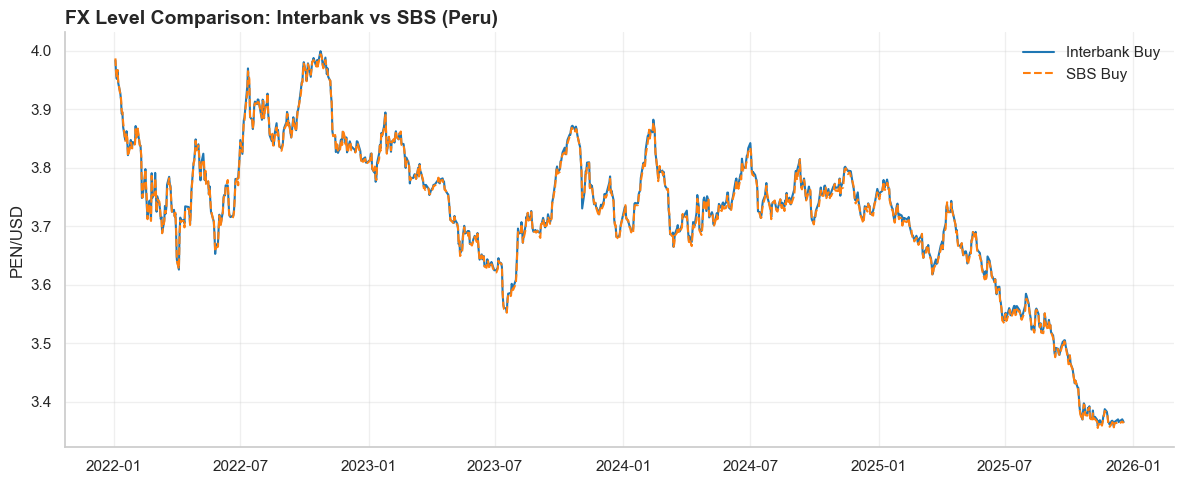

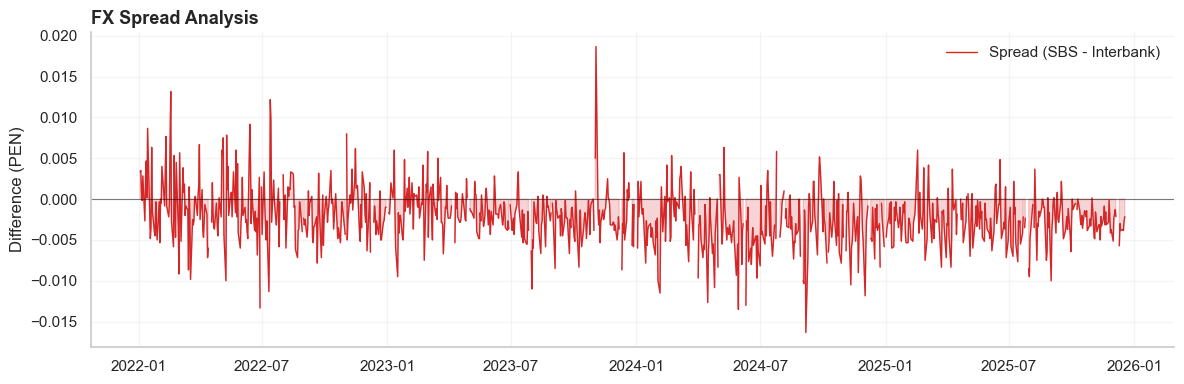

In [36]:
# Setting a clean, professional aesthetic
sns.set_theme(style="whitegrid")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Filter and ensure wide format with date as index
fx_cols = ['fx_interbank_buy', 'fx_sbs_buy']
fx_data = peru_wide.set_index('date')[fx_cols]

# Plot the FX levels in the same line chart
plt.figure(figsize=(12, 5))
# Using specific colors and line styles for better distinction
sns.lineplot(data=fx_data['fx_interbank_buy'], color='#1f77b4', label='Interbank Buy', linewidth=1.5)
sns.lineplot(data=fx_data['fx_sbs_buy'], color='#ff7f0e', label='SBS Buy', linewidth=1.5, linestyle='--')

plt.title('FX Level Comparison: Interbank vs SBS (Peru)', loc='left', fontsize=14, fontweight='bold')
plt.ylabel('PEN/USD')
plt.xlabel('') # Removing redundant x-label
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create spread = sbs - interbank and plot separately (Stylized)
fx_data['spread'] = fx_data['fx_sbs_buy'] - fx_data['fx_interbank_buy']

plt.figure(figsize=(12, 4))
# Using a filled area to highlight the magnitude of the spread
plt.fill_between(fx_data.index, fx_data['spread'], color='tab:red', alpha=0.2)
plt.plot(fx_data.index, fx_data['spread'], color='tab:red', label='Spread (SBS - Interbank)', linewidth=1)

plt.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
plt.title('FX Spread Analysis', loc='left', fontsize=13, fontweight='bold')
plt.ylabel('Difference (PEN)')
plt.xlabel('')
plt.legend(frameon=False)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 2) Proportions
## Exercise 2.1 — Share of positive-return days (USA)
Define a positive day as ret > 0.

Tasks

1. For each ticker in usa, compute the share of days with ret > 0.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

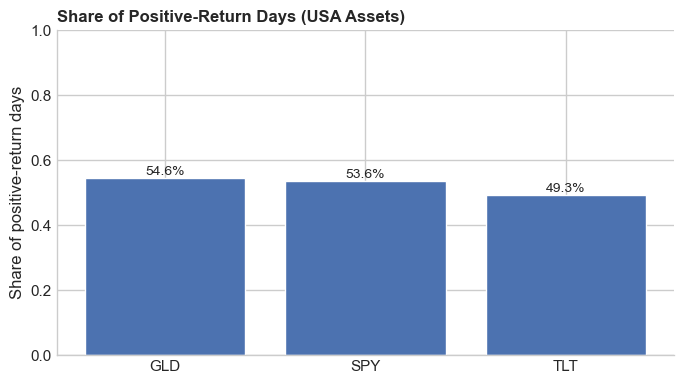

In [37]:
# Ensure returns are numeric
usa["ret"] = pd.to_numeric(usa["ret"], errors="coerce")

# 1. Share of positive-return days by ticker
share_positive = (
    usa
    .dropna(subset=["ret"])
    .groupby("ticker")["ret"]
    .apply(lambda x: (x > 0).mean())
)

plt.style.use("seaborn-v0_8-whitegrid")

# 2. Bar chart
plt.figure(figsize=(7, 4))
bars = plt.bar(
    share_positive.index,
    share_positive.values
)

# 3. Labels and title
plt.ylabel("Share of positive-return days")
plt.title("Share of Positive-Return Days (USA Assets)", loc="left", fontweight="bold")

# Clean axes
plt.ylim(0, 1)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1%}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


# 3) Distributions
## Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF
Goal: compare distributions of a Peru gold reference price series vs the US gold ETF (GLD).

Tasks

1. From peru, build a daily gold series and compute returns.
2. From usa, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

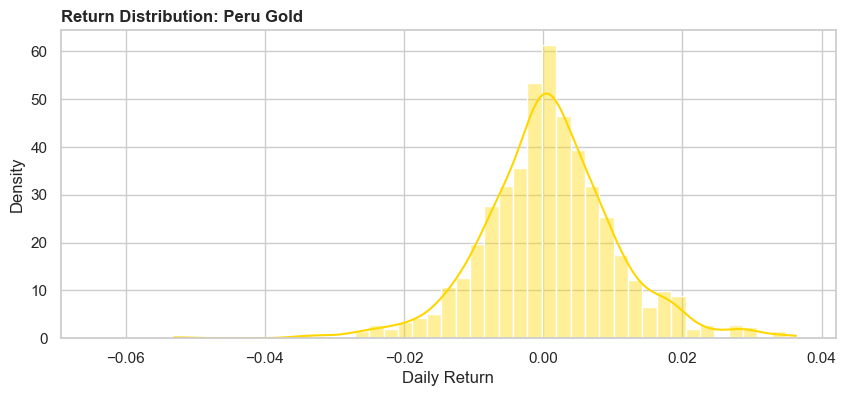

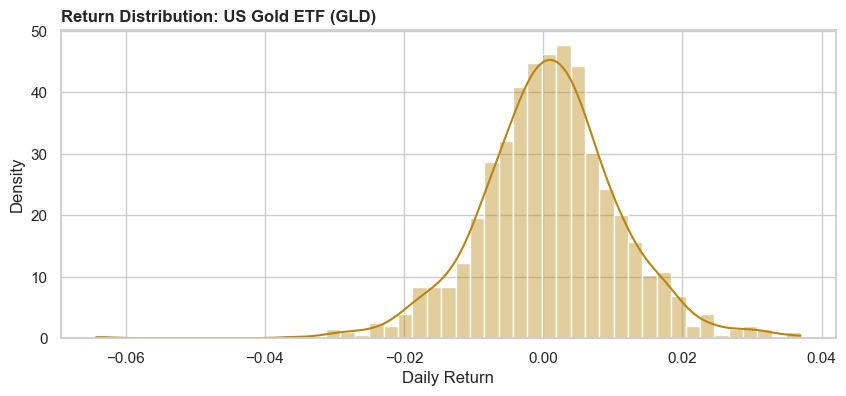

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Peru Gold returns
peru_gold = peru_wide[['date', 'gold_london']].set_index('date').sort_index()
peru_gold['ret'] = peru_gold['gold_london'].pct_change()

# Filter USA to GLD (with cleanup)
usa['ticker'] = usa['ticker'].astype(str).str.strip().str.upper()
usa_gold_data = usa[usa['ticker'] == 'GLD'].copy()
usa_gold_data['ret'] = usa_gold_data['close'].pct_change()
usa_gold_ret = usa_gold_data.set_index('date')['ret']

# Setup bins
combined = pd.concat([peru_gold['ret'], usa_gold_ret]).dropna()
bins = np.linspace(combined.min(), combined.max(), 50)

sns.set_theme(style="whitegrid")

# Figure 1: Peru Gold
plt.figure(figsize=(10, 4))
sns.histplot(
    peru_gold['ret'].dropna(),
    bins=bins,
    stat='density',
    kde=True,
    color='gold',
    alpha=0.4
)
plt.title('Return Distribution: Peru Gold', loc='left', fontweight='bold')
plt.xlabel('Daily Return')
plt.show()

# Figure 2: US Gold ETF
plt.figure(figsize=(10, 4))
sns.histplot(
    usa_gold_ret.dropna(),
    bins=bins,
    stat='density',
    kde=True,
    color='darkgoldenrod',
    alpha=0.4
)
plt.title('Return Distribution: US Gold ETF (GLD)', loc='left', fontweight='bold')
plt.xlabel('Daily Return')
plt.show()

# 4) Relationships
## Exercise 4.1 — FX changes vs market returns (Peru + USA)
Use:

- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)
Tasks

1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from usa.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

C:\Users\User\AppData\Local\Temp\ipykernel_22588\3608633100.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  peru_fx["fx_ret"] = peru_fx["fx_interbank_buy"].pct_change()


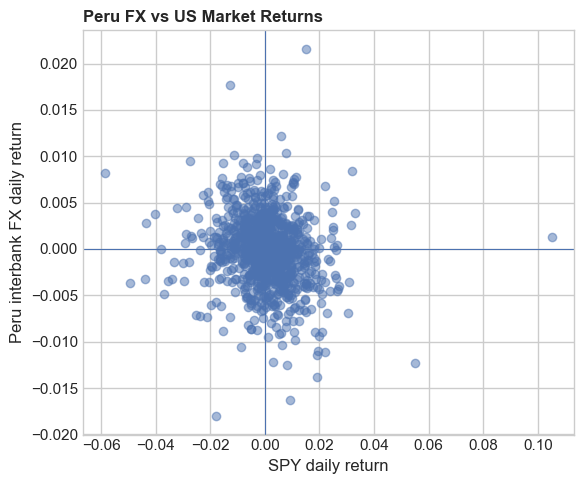

Correlation (FX vs SPY): -0.172


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Peru: Interbank FX daily returns
peru_fx = (
    peru_wide[["date", "fx_interbank_buy"]]
    .set_index("date")
    .sort_index()
)

peru_fx["fx_ret"] = peru_fx["fx_interbank_buy"].pct_change()

# 2. USA: SPY daily returns
usa_spy = (
    usa[usa["ticker"] == "SPY"]
    .set_index("date")
    .sort_index()
)

usa_spy["spy_ret"] = usa_spy["close"].pct_change()

# 3. Merge on date
df_fx_spy = (
    peru_fx[["fx_ret"]]
    .merge(
        usa_spy[["spy_ret"]],
        left_index=True,
        right_index=True,
        how="inner"
    )
    .dropna()
)

# 4. Scatter plot
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(6, 5))
plt.scatter(
    df_fx_spy["spy_ret"],
    df_fx_spy["fx_ret"],
    alpha=0.5
)

plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)

plt.xlabel("SPY daily return")
plt.ylabel("Peru interbank FX daily return")
plt.title(
    "Peru FX vs US Market Returns",
    loc="left",
    fontweight="bold"
)

plt.tight_layout()
plt.show()

# 5. Correlation
corr_fx_spy = df_fx_spy["fx_ret"].corr(df_fx_spy["spy_ret"])
print(f"Correlation (FX vs SPY): {corr_fx_spy:.3f}")

# 5) References
- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

# 2) Online Data Sources
## Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will inspect what is being requested.

Tasks

1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using http_get_text and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [40]:
import requests

# Function to download text data from a URL
def http_get_text(url):
    # Add a browser-like header to avoid 403 error
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    # Send HTTP GET request
    r = requests.get(url, headers=headers)
    # Raise error if request failed
    r.raise_for_status()
    # Return response as plain text
    return r.text


# BCRP API URL for a Peru economic series
api_url = (
    "https://estadisticas.bcrp.gob.pe/estadisticas/series/api/"
    "PD04637PD/csv"
    "?periodo_desde=2022-01-01"
    "&periodo_hasta=2025-12-31"
)

# Print the requested API URL
print(api_url)

# Download CSV content from the API
csv_text = http_get_text(api_url)

# Display the first 10 lines of the CSV file
for line in csv_text.splitlines()[:10]:
    print(line)

https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD/csv?periodo_desde=2022-01-01&periodo_hasta=2025-12-31
D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra"<br>"20.Nov.25","3.37857142857143"<br>"21.Nov.25","3.38714285714286"<br>"24.Nov.25","3.38285714285714"<br>"25.Nov.25","3.37514285714286"<br>"26.Nov.25","3.365"<br>"27.Nov.25","3.36414285714286"<br>"28.Nov.25","3.36071428571429"<br>"01.Dic.25","3.36714285714286"<br>"02.Dic.25","3.36728571428571"<br>"03.Dic.25","3.36285714285714"<br>"04.Dic.25","3.35728571428571"<br>"05.Dic.25","3.36514285714286"<br>"10.Dic.25","3.36971428571429"<br>"11.Dic.25","3.365"<br>"12.Dic.25","3.36685714285714"<br>"15.Dic.25","3.36871428571429"<br>"16.Dic.25","3.36985714285714"<br>"17.Dic.25","3.36771428571429"<br>"18.Dic.25","3.36514285714286"<br>"19.Dic.25","3.36614285714286"<br>"22.Dic.25","3.36457142857143"<br>"23.Dic.25","3.36557142857143"<br>"24.Dic.25","3.3628"<br>"29.Dic.25","3.36528571428571"<br>"30.Dic.

Explanation of the BCRP API URL
Base URL

https://estadisticas.bcrp.gob.pe/estadisticas/series/api/
Official API endpoint of the Central Reserve Bank of Peru (BCRP)
Provides access to Peru’s economic time series
Series code

PD04637PD
Unique identifier of the requested economic indicator
Each BCRP series has its own code
Format

/csv
Specifies that the data is returned in CSV format
Suitable for direct use in data analysis
Query parameters

periodo_desde=2022-01-01
Start date of the time series
periodo_hasta=2025-12-31
End date of the time series
Overall

The URL requests historical data for a Peruvian economic series
The response is plain-text CSV data obtained through an HTTP request

## Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

Tasks
1. Use peru_w (already wide).
2. Rename columns to short names:
3. fx_interbank, fx_sbs, gold, copper (Hint: inspect column names first.)
4. Create daily percentage changes for FX and commodities.
5. Drop rows where all four returns are missing.

In [42]:
peru_wide.columns

Index(['date', 'copper_london', 'gold_london', 'fx_interbank_buy', 'fx_sbs_buy'], dtype='object')

In [43]:
# Ensure date column is the index (if not already)
peru_wide = peru_wide.set_index("date")

# Keep only numeric columns
peru_wide = peru_wide.apply(pd.to_numeric, errors="coerce")

# Rename columns
peru_wide = peru_wide.rename(columns={
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "gold",
    "PD04701XD": "copper"
})

# Compute daily percentage changes without forward-filling
peru_ret = peru_wide.pct_change(fill_method=None)

# Drop rows where all four returns are missing
peru_ret = peru_ret.dropna(how="all")

# Show result
peru_ret.head()

,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
date,,,,
2022-01-04,-0.003302,-0.004780,-0.006066,-0.006020
2022-01-05,0.012215,0.008198,-0.001894,-0.002523
2022-01-06,-0.021784,-0.020205,0.003838,0.003542
2022-01-07,0.005227,0.001816,-0.005546,-0.004790
2022-01-10,0.005200,0.000893,-0.004436,-0.005826


# 3) Matplotlib: Constructing the Plot
## Exercise 3.1
Create a single figure with 2 subplots:

* Top: Peru FX spread (SBS - interbank)
* Bottom: USA SPY close price

Tasks
1. Build the Peru FX spread series from peru_w.
2. Build SPY close series from usa_w.
3. Use plt.subplots(nrows=2, ncols=1, sharex=True).
4. Add titles, axis labels, and use fig.tight_layout().

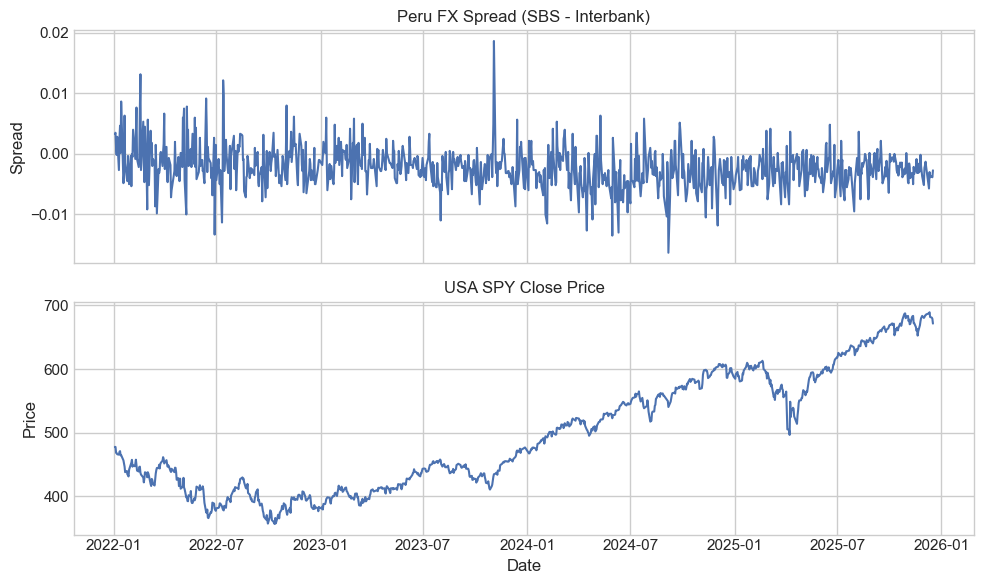

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Rename Peru columns ---
peru_wide = peru_wide.rename(columns={
    "fx_interbank_buy": "fx_interbank",
    "fx_sbs_buy": "fx_sbs",
    "gold_london": "gold",
    "copper_london": "copper"
}).copy()

# --- 2) Make sure date index is datetime (Peru) ---
peru_wide.index = pd.to_datetime(peru_wide.index, errors="coerce")
peru_wide = peru_wide.loc[peru_wide.index.notna()].sort_index()

# --- 3) Build Peru FX spread ---
fx_spread = (peru_wide["fx_sbs"] - peru_wide["fx_interbank"]).dropna()
fx_spread.name = "fx_spread"

# --- 4) Extract SPY close robustly from `usa` ---
usa = usa.copy()

def get_spy_close(df: pd.DataFrame) -> pd.Series:
    # Case A: MultiIndex columns from yfinance style: ('Close','SPY') or ('Adj Close','SPY')
    if isinstance(df.columns, pd.MultiIndex):
        for lvl0 in ["Close", "Adj Close"]:
            if (lvl0, "SPY") in df.columns:
                s = df[(lvl0, "SPY")].copy()
                s.name = "SPY_close"
                return s

    # Case B: Wide columns with tickers (SPY is a column)
    if "SPY" in df.columns:
        s = pd.to_numeric(df["SPY"], errors="coerce").dropna()
        s.name = "SPY_close"
        return s

    # Case C: Long format with columns like ['date','ticker','close'] (or 'symbol', 'adj_close', etc.)
    cols_lower = {c.lower(): c for c in df.columns}

    ticker_col = cols_lower.get("ticker") or cols_lower.get("symbol")
    date_col = cols_lower.get("date")
    close_col = (cols_lower.get("close") or cols_lower.get("adj close") or cols_lower.get("adj_close"))

    if ticker_col and close_col:
        tmp = df.copy()

        # If date is in a column, set it as index
        if date_col:
            tmp[date_col] = pd.to_datetime(tmp[date_col], errors="coerce")
            tmp = tmp.loc[tmp[date_col].notna()].set_index(date_col).sort_index()
        else:
            # otherwise assume index is date-like
            tmp.index = pd.to_datetime(tmp.index, errors="coerce")
            tmp = tmp.loc[tmp.index.notna()].sort_index()

        tmp = tmp.loc[tmp[ticker_col] == "SPY"]
        s = pd.to_numeric(tmp[close_col], errors="coerce").dropna()
        s.name = "SPY_close"
        return s

    # Fallback: try first numeric column (avoid strings like GLD/SPY/TLT)
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if numeric_cols:
        s = df[numeric_cols[0]].copy()
        s.index = pd.to_datetime(df.index, errors="coerce")
        s = s.loc[s.index.notna()].sort_index()
        s.name = "SPY_close"
        return s

    raise ValueError("Could not extract SPY close: `usa` seems not to contain numeric close prices.")

spy_close = get_spy_close(usa)

# --- 5) Ensure datetime index for SPY series and align periods ---
spy_close.index = pd.to_datetime(spy_close.index, errors="coerce")
spy_close = spy_close.loc[spy_close.index.notna()].sort_index()

common_index = fx_spread.index.intersection(spy_close.index)
fx_spread_aligned = fx_spread.loc[common_index]
spy_close_aligned = spy_close.loc[common_index]

# --- 6) Plot (clean) ---
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

axes[0].plot(fx_spread_aligned)
axes[0].set_title("Peru FX Spread (SBS - Interbank)")
axes[0].set_ylabel("Spread")

axes[1].plot(spy_close_aligned)
axes[1].set_title("USA SPY Close Price")
axes[1].set_ylabel("Price")
axes[1].set_xlabel("Date")

fig.tight_layout()
plt.show()

## Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

Tasks

1. Find the date with the largest abs(ret) for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

Date with largest |SPY return|: 1970-01-01
Largest absolute return: 10.5019%


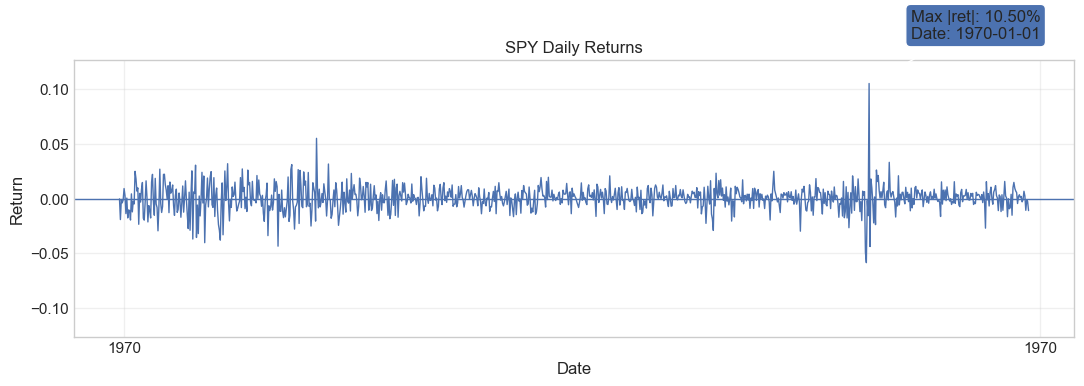

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Ensure datetime index (usa should have dates in the index) ---
usa = usa.copy()
usa.index = pd.to_datetime(usa.index, errors="coerce")
usa = usa.loc[usa.index.notna()].sort_index()

# --- 2) Keep only SPY rows (long format) ---
spy_df = usa.loc[usa["ticker"] == "SPY"].copy()

# Keep last observation if there are duplicate dates
spy_df = spy_df.groupby(spy_df.index).last().sort_index()

# --- 3) Build SPY returns ---
# Option A (recommended): compute from close (more reliable)
spy_close = pd.to_numeric(spy_df["close"], errors="coerce").dropna()
spy_ret = spy_close.pct_change().dropna()

# Optional: remove absurd glitches (just for plotting & stable extreme)
spy_ret = spy_ret[spy_ret.abs() < 0.20]  # 20% cap is safe

# --- 4) Find extreme date/value ---
extreme_date = spy_ret.abs().idxmax()
extreme_ret = float(spy_ret.loc[extreme_date])

print("Date with largest |SPY return|:", extreme_date.date())
print("Largest absolute return:", f"{extreme_ret:.4%}")

# --- 5) Plot returns and annotate (boxed + neat) ---
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(spy_ret, linewidth=1)
ax.axhline(0, linewidth=1)

ax.set_title("SPY Daily Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.grid(True, alpha=0.3)

# symmetric y-limits for nice look
ymax = float(np.nanmax(np.abs(spy_ret.values)))
ax.set_ylim(-ymax * 1.2, ymax * 1.2)

label = f"Max |ret|: {extreme_ret:.2%}\nDate: {extreme_date.date()}"

ax.annotate(
    label,
    xy=(extreme_date, extreme_ret),
    xytext=(30, 30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
    bbox=dict(boxstyle="round,pad=0.3"),
    ha="left",
    va="bottom"
)

fig.tight_layout()
plt.show()


## Exercise 3.3 — Saving the figure
Save one of your figures to disk.

Tasks

Create a folder figures/ if it does not exist.
Save the subplot figure as figures/lecture4II_fx_spy.png with dpi=150.
Confirm the file exists.

In [46]:
import os

# 1) Create folder 'figures/' if it does not exist
os.makedirs("figures", exist_ok=True)

# 2) Save the figure with dpi=150
fig_path = "figures/lecture4II_fx_spy.png"
fig.savefig(fig_path, dpi=150)

# 3) Confirm the file exists
print("File exists:", os.path.exists(fig_path))
print("Saved at:", fig_path)


File exists: True
Saved at: figures/lecture4II_fx_spy.png


# 4) Statistics
## Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

Tasks
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.